In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook

In [2]:
import sys, os
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

# FENICSx imports
import ufl
import dolfinx
from mpi4py import MPI
from petsc4py.PETSc import ScalarType as dtype

sys.path.append('..')
%aimport mre_pinn

dtype

Using backend: pytorch



numpy.complex128

## 2D Helmholtz inverse FEM

We want to solve for the elasticity field $\mu: \Omega \to \mathbb{C}$ given the wave field $u: \Omega \to \mathbb{C}^2$, where $\Omega \subset \mathbb{R}^2$.

Strong form:

$$
\begin{align}
    \mu(\mathbf{x}) \nabla^2 u(\mathbf{x}) + \rho \omega^2 u(\mathbf{x}) &= 0
\end{align}
$$

In [3]:
%autoreload

# load the data set
data, _ = mre_pinn.data.load_bioqic_dataset(
    data_root='../data/BIOQIC',
    data_name='fem_box',
    frequency=80,
    xyz_slice='2D'
)
data

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_elastogram.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Loading ../data/BIOQIC/fem_box_regions.npy
     <class 'numpy.ndarray'> (10, 80, 100) int64
Single frequency 2D
<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
Data variables:
    u               (frequency, x, y, component) complex128 (-4.2190458277627...
    mu              (frequency, x, y) complex128 (3000+502.6548245743669j) .....
    spatial_region  (x, y) int64 

<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
Data variables:
    u               (frequency, x, y, component) complex128 (-4.2190458277627...
    mu              (frequency, x, y) complex128 (3000+502.6548245743669j) .....
    spatial_region  (x, y) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    Lu              (frequency, x, y, component) complex128 (-0.0057547091471...
    Mu              (frequency, x, y) complex128 (3768.976611513677-1443.9860...

<IPython.core.display.Javascript object>


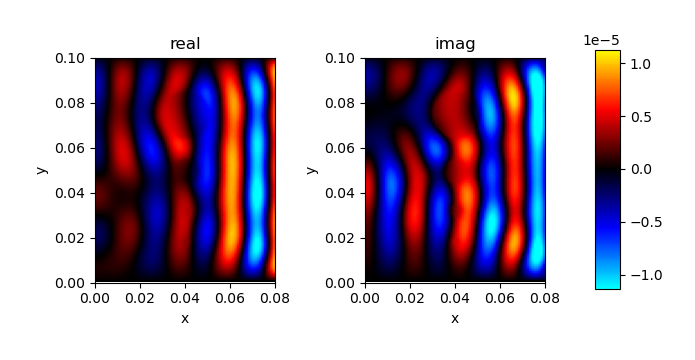

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


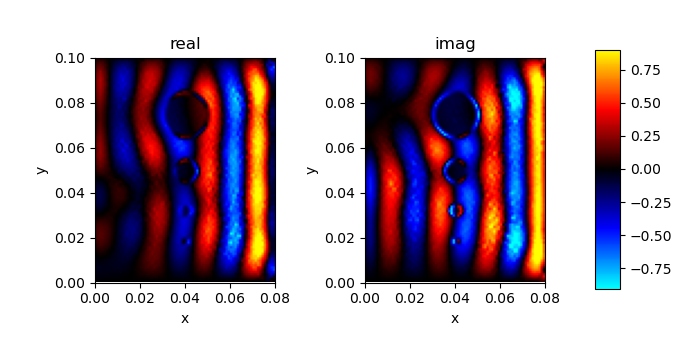

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


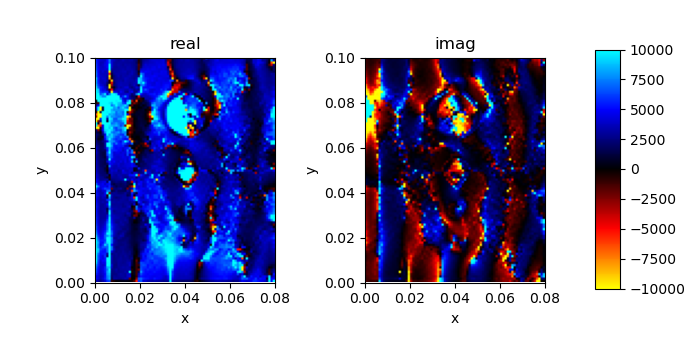

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


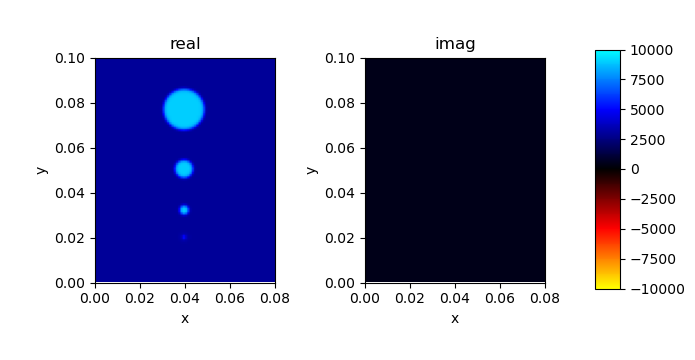

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [246]:
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu)
elast_kws = mre_pinn.visual.get_color_kws(data.mu)

mre_pinn.visual.XArrayViewer(data.u, col='part', ax_width=2, **wave_kws)
mre_pinn.visual.XArrayViewer(data.Lu, col='part', ax_width=2, **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu, col='part', ax_width=2, **elast_kws)
mre_pinn.visual.XArrayViewer(data.mu, col='part', ax_width=2, **elast_kws)

<IPython.core.display.Javascript object>


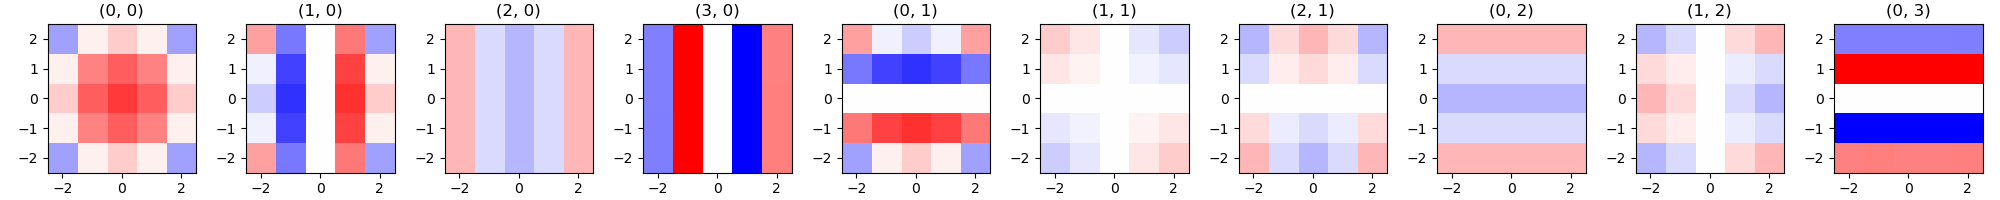

In [247]:
def sg_filter_nd(n, order=2, kernel_size=3, deriv=None):
    '''
    N-dimensional Savitsky-Golay filter.
    '''
    assert kernel_size % 2 == 1, 'kernel_size must be odd'
    
    # relative coordinates of kernel values
    half_size = kernel_size // 2
    coords = np.arange(-half_size, half_size + 1)
    coords = np.stack(np.meshgrid(*[coords] * n), axis=-1).reshape(-1, n)
    n_values = len(coords)
    
    # powers of polynomial terms
    powers = np.arange(order + 1)
    powers = np.stack(np.meshgrid(*[powers] * n), axis=-1).reshape(-1, n)
    powers = powers[powers.sum(axis=1) <= order]
    n_terms = len(powers)
    
    assert n_values >= n_terms, 'order is too high for kernel_size'
    
    # set up linear system of equations
    A = np.zeros((n_values, n_terms))
    for i in range(n_values):
        for j in range(n_terms):
            A[i,j] = np.power(coords[i], powers[j]).prod()
    
    kernels = np.linalg.pinv(A)
    
    # this factor is needed for correct derivative kernels
    kernels *= scipy.special.factorial(powers).prod(axis=1, keepdims=True)

    kernel_shape = (kernel_size,) * n
    kernels = kernels.reshape(-1, *kernel_shape)
    
    # return mapping from derivative order to kernel
    return {tuple(p): k for p, k in zip(powers, kernels)}

kernels = sg_filter_nd(n=2, order=1, kernel_size=3)
kernels = sg_filter_nd(n=2, order=3, kernel_size=5)

# visualize the kernels
fig, axes = plt.subplots(1, len(kernels), figsize=(len(kernels) * 2, 2))
for i, (deriv, kernel) in enumerate(kernels.items()):
    kernel_size = kernel.shape[-1]
    half_size = kernel_size // 2
    extent = [-half_size - 0.5, half_size + 0.5, -half_size - 0.5, half_size + 0.5]
    vmax = 1 / kernel_size
    axes[i].imshow(kernel, cmap='bwr', vmin=-vmax, vmax=vmax, extent=extent)
    axes[i].set_title(deriv)

fig.tight_layout()

<IPython.core.display.Javascript object>


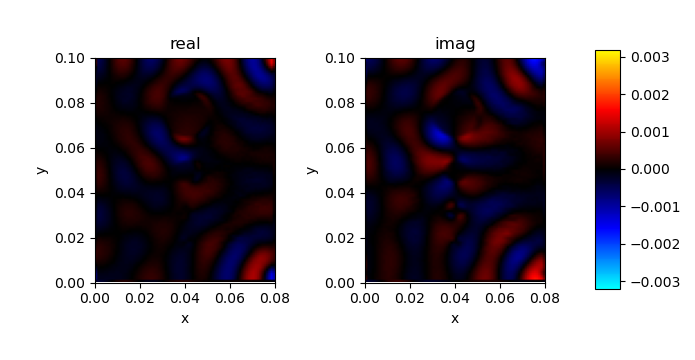

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


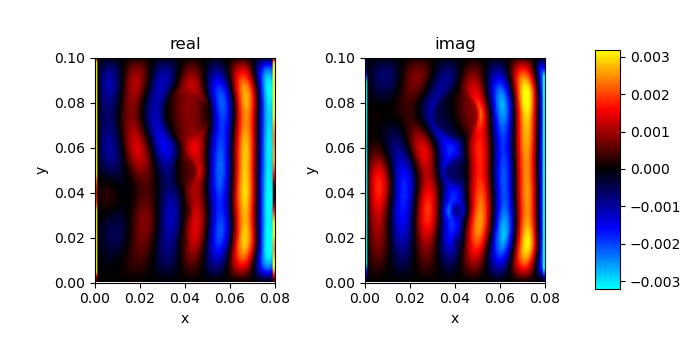

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


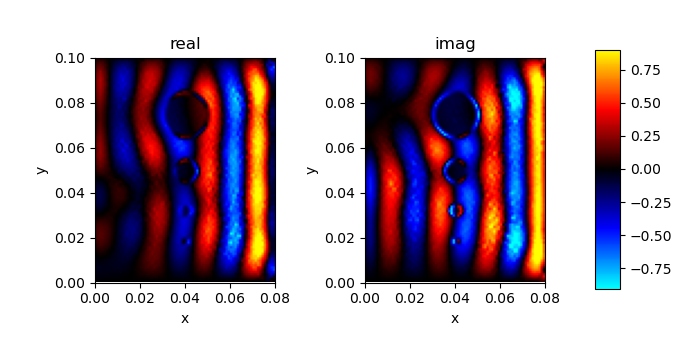

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


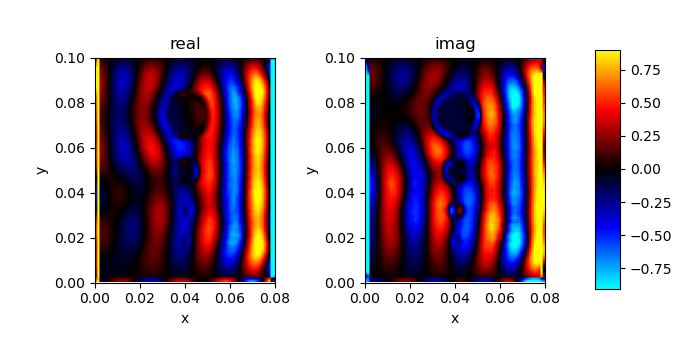

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


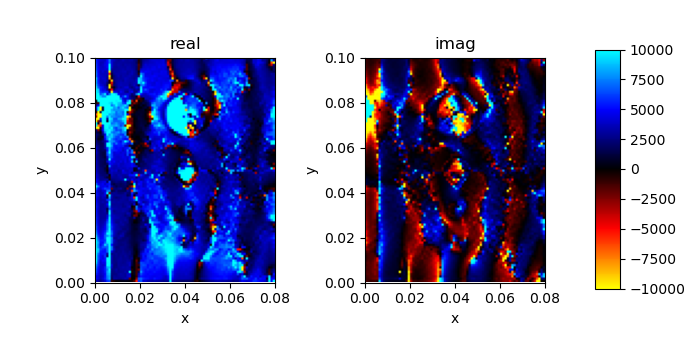

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


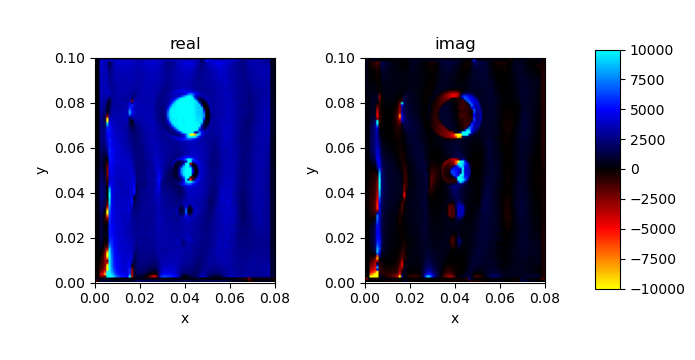

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [275]:
from scipy.ndimage import convolve

kernels = sg_filter_nd(n=2, order=1, kernel_size=3)

dx = 1e-3
data['Dxu_pred'] = data.u * 0
data.Dxu_pred[0,:,:,0] = convolve(data.u[0,:,:,0], kernels[(1,0)], mode='wrap') / dx
data.Dxu_pred[0,:,:,1] = convolve(data.u[0,:,:,1], kernels[(1,0)], mode='wrap') / dx

data['Dyu_pred'] = data.u * 0
data.Dyu_pred[0,:,:,0] = convolve(data.u[0,:,:,0], kernels[(0,1)], mode='wrap') / dx
data.Dyu_pred[0,:,:,1] = convolve(data.u[0,:,:,1], kernels[(0,1)], mode='wrap') / dx

jacob_kws = mre_pinn.visual.get_color_kws(data.Jux_pred)

mre_pinn.visual.XArrayViewer(data.Dxu_pred, col='part', ax_width=2, **jacob_kws)
mre_pinn.visual.XArrayViewer(data.Dyu_pred, col='part', ax_width=2, **jacob_kws)

kernels = sg_filter_nd(n=2, order=3, kernel_size=5)

data['Lu_pred'] = data.u * 0
data.Lu_pred[0,:,:,0] = (convolve(data.u[0,:,:,0], kernels[(2,0)], mode='wrap') + convolve(data.u[0,:,:,0], kernels[(0,2)], mode='wrap')) / dx**2
data.Lu_pred[0,:,:,1] = (convolve(data.u[0,:,:,1], kernels[(2,0)], mode='wrap') + convolve(data.u[0,:,:,0], kernels[(0,2)], mode='wrap')) / dx**2

mre_pinn.visual.XArrayViewer(data.Lu, col='part', ax_width=2, **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Lu_pred, col='part', ax_width=2, **laplace_kws)

data['Mu_pred'] = mre_pinn.discrete.helmholtz_inversion(data.u, data.Lu_pred) * 2

mre_pinn.visual.XArrayViewer(data.Mu, col='part', ax_width=2, **elast_kws)
mre_pinn.visual.XArrayViewer(data.Mu_pred, col='part', ax_width=2, **elast_kws)

In [287]:
# determine the domain from wave image data
print(data.u.shape)
n_frequency, n_x, n_y, n_component = data.u.shape

x = data.u.field.spatial_points()
u = data.u.field.values()
Dxu = data.Dxu_pred.field.values()
Dyu = data.Dyu_pred.field.values()
Lu = data.Lu_pred.field.values()
print(x.shape, u.shape, Lu.shape)

x_min = x.min(axis=0)
x_max = x.max(axis=0)

print(x_min, x_max)

# define the mesh and FEM basis
mesh = dolfinx.mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[x_min, x_max],
    n=[n_x, n_y // 2 - 1],
    cell_type=dolfinx.mesh.CellType.triangle,
    diagonal=dolfinx.mesh.DiagonalType.right_left
)
print(mesh.geometry.x.shape)

mu_func_space = dolfinx.fem.FunctionSpace(mesh, ('Lagrange', 1))
u_func_space = dolfinx.fem.VectorFunctionSpace(mesh, ('Lagrange', 1), dim=2)
Ju_func_space = dolfinx.fem.TensorFunctionSpace(mesh, ('Lagrange', 1), shape=(2,2))

(1, 80, 100, 2)
(8000, 2) (8000, 2) (8000, 2)
[0. 0.] [0.079 0.099]
(2000, 3)


<IPython.core.display.Javascript object>


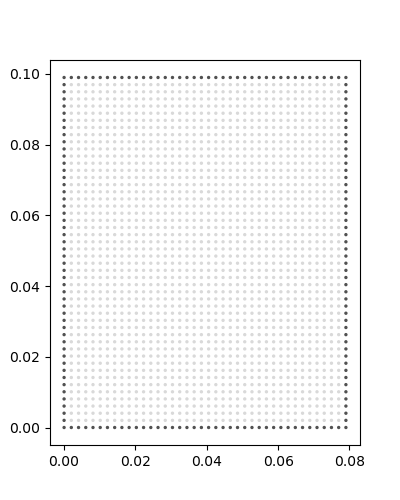

In [288]:
# identify boundary nodes

def on_boundary(x):
    x = x[:2] # assume only 2D
    x_loc = x.mean(axis=1, keepdims=True)
    x_scale = (x.max(axis=1, keepdims=True) - x.min(axis=1, keepdims=True)) / 2
    x = (x - x_loc) / x_scale
    return np.isclose(np.linalg.norm(x, np.inf, axis=0), 1)

nodes = mesh.geometry.x
boundary = on_boundary(nodes.T)
c = (boundary / 2) + 1 / 4

fig, ax = plt.subplots(figsize=(4, 5))
ax.scatter(*nodes.T[:2], c=c, s=2, cmap='Greys', vmin=0, vmax=1)

In [289]:
# setup physical problem and boundary conditions

# physical constants
rho = 1000
omega = 2 * np.pi * 80

# function for interpolating wave image into FEM basis
u_interp = scipy.interpolate.LinearNDInterpolator(points=x, values=u)
u_func = dolfinx.fem.Function(u_func_space)
u_func.interpolate(lambda x: np.ascontiguousarray(u_interp(x[:2].T).T))

# function for interpolating Jacobian into FEM basis
Dxu_interp = scipy.interpolate.LinearNDInterpolator(points=x, values=Dxu)
Dyu_interp = scipy.interpolate.LinearNDInterpolator(points=x, values=Dyu)

def Ju_interp(x):
    return np.stack([
        Dxu_interp(x),
        Dyu_interp(x)
    ], axis=1)

def f(x):
    return np.ascontiguousarray(Ju_interp(x[:2].T).T.reshape(4, -1))

Ju_func = dolfinx.fem.Function(Ju_func_space)
Ju_func.interpolate(f)

# function for interpolating Laplacian into FEM basis
Lu_interp = scipy.interpolate.LinearNDInterpolator(points=x, values=Lu)
Lu_func = dolfinx.fem.Function(u_func_space)
Lu_func.interpolate(lambda x: np.ascontiguousarray(Lu_interp(x[:2].T).T))

# elasticity boundary condition (do we need this?)
mu_func = dolfinx.fem.Function(mu_func_space)
mu_func.interpolate(lambda x: np.ascontiguousarray(3e3 * np.ones_like(x[0])))

boundary_dofs = dolfinx.fem.locate_dofs_geometrical(mu_func_space, on_boundary)
mu_bc = dolfinx.fem.dirichletbc(mu_func, dofs=boundary_dofs)

Helmholtz equation in variational form:

$$
\begin{align}
    \int_\Omega \mu \nabla u \cdot \nabla \bar{v} d\Omega &= \int_\Omega \rho \omega^2 u \bar{v} d\Omega
\end{align}
$$

Helmholtz equation in variational form with polynomial Laplacian:

$$
\begin{align}
    -\int_\Omega \mu \nabla^2 u \cdot \bar{v} d\Omega &= \int_\Omega \rho \omega^2 u \bar{v} d\Omega
\end{align}
$$

Heterogeneous equation in variational form:

$$
\begin{align}
    \int_\Omega \left( \mu \nabla u \cdot \nabla \bar{v} - \nabla \mu \cdot \nabla u \bar{v} \right) d\Omega &= \int_\Omega \rho \omega^2 u \bar{v} d\Omega
\end{align}
$$

In [294]:
%%time
import ufl

# solve variational Helmholtz problem
mu_func = ufl.TrialFunction(mu_func_space)
v_func = ufl.TestFunction(u_func_space)

f_func = dolfinx.fem.Function(mu_func_space) # source is zero
f_func.interpolate(lambda x: 0 * x[:1])

#Ax = mu_func * ufl.inner(ufl.grad(u_func), ufl.grad(v_func)) * ufl.dx
Ax = -mu_func * ufl.inner(Lu_func, v_func) * ufl.dx
#Ax = (mu_func * ufl.inner(ufl.grad(u_func), ufl.grad(v_func)) - ufl.inner(ufl.grad(mu_func), ufl.grad(u_func) * v_func)) * ufl.dx
#Ax = (-mu_func * ufl.inner(Lu_func, v_func) - ufl.inner(ufl.grad(mu_func), Ju_func * v_func)) * ufl.dx
b = rho * omega**2 * ufl.inner(u_func, v_func) * ufl.dx

problem = dolfinx.fem.petsc.LinearProblem(
    Ax, b, bcs=[], petsc_options={"ksp_type": "lsqr", "pc_type": "none"}
)
mu_pred_func = problem.solve()

CPU times: user 120 ms, sys: 991 µs, total: 121 ms
Wall time: 44.8 ms


<IPython.core.display.Javascript object>


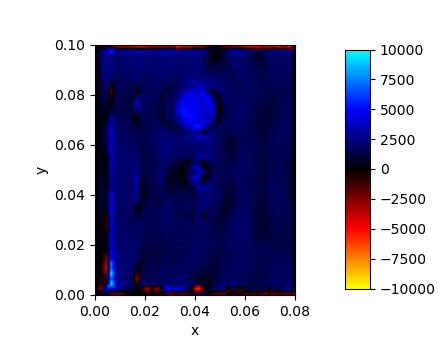

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [295]:
def eval_func(f_h, x):
    '''
    Evaluate a dolfinx function on a set of points.
    '''
    # ensure x has 3 spatial dimensions
    x = np.concatenate(
        [x, np.zeros((x.shape[0], 3 - x.shape[1]))], 
    axis=1)
    tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
    cells = dolfinx.geometry.compute_collisions(tree, x)
    cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
    cells = [cells.links(i)[0] for i in range(len(x))]
    return f_h.eval(x, cells)

# evaluate function on mesh
mu_pred = eval_func(mu_pred_func, x)
mu_pred = mu_pred.reshape(*data.mu.shape)
mu_pred.shape, mu_pred.dtype

# visualize the elastogram
data['mu_pred'] = mre_pinn.utils.as_xarray(mu_pred, like=data.mu)
mre_pinn.visual.XArrayViewer(data.mu_pred, ax_width=2, **elast_kws)